# Week 4 - Linear Methods for Regression

Today we will:
- refresh our knowledge of linear models for regression
- сonstruct a base for the study of non-linear methods
- dive into the application of the Python language

In [6]:
import pandas as pd, statsmodels.api as sm, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import itertools
from scipy.stats import f
sns.set_style("darkgrid")

# Linear Model

The linear regression has the form
$$f(X) = \beta_0 + \sum_{j=1}^p{X_i \beta_j}$$

where the variables $X_j$ can come from different sources:
- quantitative inputs
- transformations of quantitative inputs ($log{X}$, $\sqrt{X}$, $X^2$, etc.)
- basis expansions leading to polynomial representation ($X_2 = X_1^2$, $X_3 = X_1^3$, ...)
- numeric coding of the levels of qualitative inputs ($X_j = I(G = j)$, where $j = 1, ..., N$ and $G$ is $N$-level factor input)
- interactions between variables ($X_3 = X_1 \cdot X_2$)

The goal is to estimate the parameters $\beta$. The most popular estimation method is *least squares*, in which we pick the coefficients $\beta = (\beta_0, \beta_1,...,\beta_p)^T$ to minimize the residual sum of squares

$$\mathrm{RSS}(\beta) = \sum_{i=1}^N{(y_i - f(x_i))^2} = \sum_{i=1}^N{(y_i - \beta_0 - \sum_{j=1}^p{x_{ij} \beta_j})^2}$$

How do we minimize the RSS? Denote by **X** the $N \times (p+1)$ matrix with each row an input  vector (with a 1 in the first position). and similarly let **y** be the $N$-vector of outputs in the training set. Then we can write the residual sum-of-squares as

$$\mathrm{RSS}(\beta) = (\boldsymbol{y} - \boldsymbol{X}\beta)^T (\boldsymbol{y} - \boldsymbol{X}\beta)$$

This is quadratic function in the $p+1$ parameters. Differentiating with repect to $\beta$ we obtain

$$\frac{\partial \mathrm{RSS}}{\partial \beta} = -2 \boldsymbol{X}^T (\boldsymbol{y} - \boldsymbol{X}\beta)$$

$$\frac{\partial^2 \mathrm{RSS}}{\partial \beta \partial \beta^T} = 2 \boldsymbol{X}^T \boldsymbol{X}$$

Assuming (for the moment) that **X** has full column rank, and hence $\boldsymbol{X}^T \boldsymbol{X}$ is positive definite, we set the first derivative to zero

$$\boldsymbol{X}^T ({y} - \boldsymbol{X}\beta) = 0$$

to obtain the unique solution

$$\hat{\beta} = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y}$$

The predicted values at an input vector $x_0$ are given by $\hat{f}(x_0) = (1: x_0)^T \hat{\beta}$; the fitted values at the training inputs are

$$\hat{\boldsymbol{y}} = \boldsymbol{X}\hat{\beta} = \boldsymbol{X} (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y}$$

where $\hat{y}_i = \hat{f}(x_i)$. The matrix $\boldsymbol{H} = \boldsymbol{X} (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T$ appearing in the equation above is sometimes called the "hat" matrix because it puts the hat on **y**.

**Example: Prostate cancer dataset**

Source: Stamey, T., Kabalin, J., McNeal, J., Johnstone, I., Freiha, F., Redwine, E. and Yang, N (1989) Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate II. Radical prostatectomy treted patients, Journall of Urology 16: 1076–1083.

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/omelnikov/data/main/prostate/prostate.data", sep = '\t', index_col=0)

In [8]:
# Inspect the header of the dataset
print(df.columns)

Index(['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45',
       'lpsa', 'train'],
      dtype='object')


In [9]:
# Inspect the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 1 to 97
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
 9   train    97 non-null     object 
dtypes: float64(5), int64(4), object(1)
memory usage: 8.3+ KB
None


In [10]:
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


The response on interest in this data set is lpsa (log prostate specific antigen).

In [11]:
# Partitioning information
df.loc[:, ["train"]].value_counts()

train
T        67
F        30
Name: count, dtype: int64

/Users/admin/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


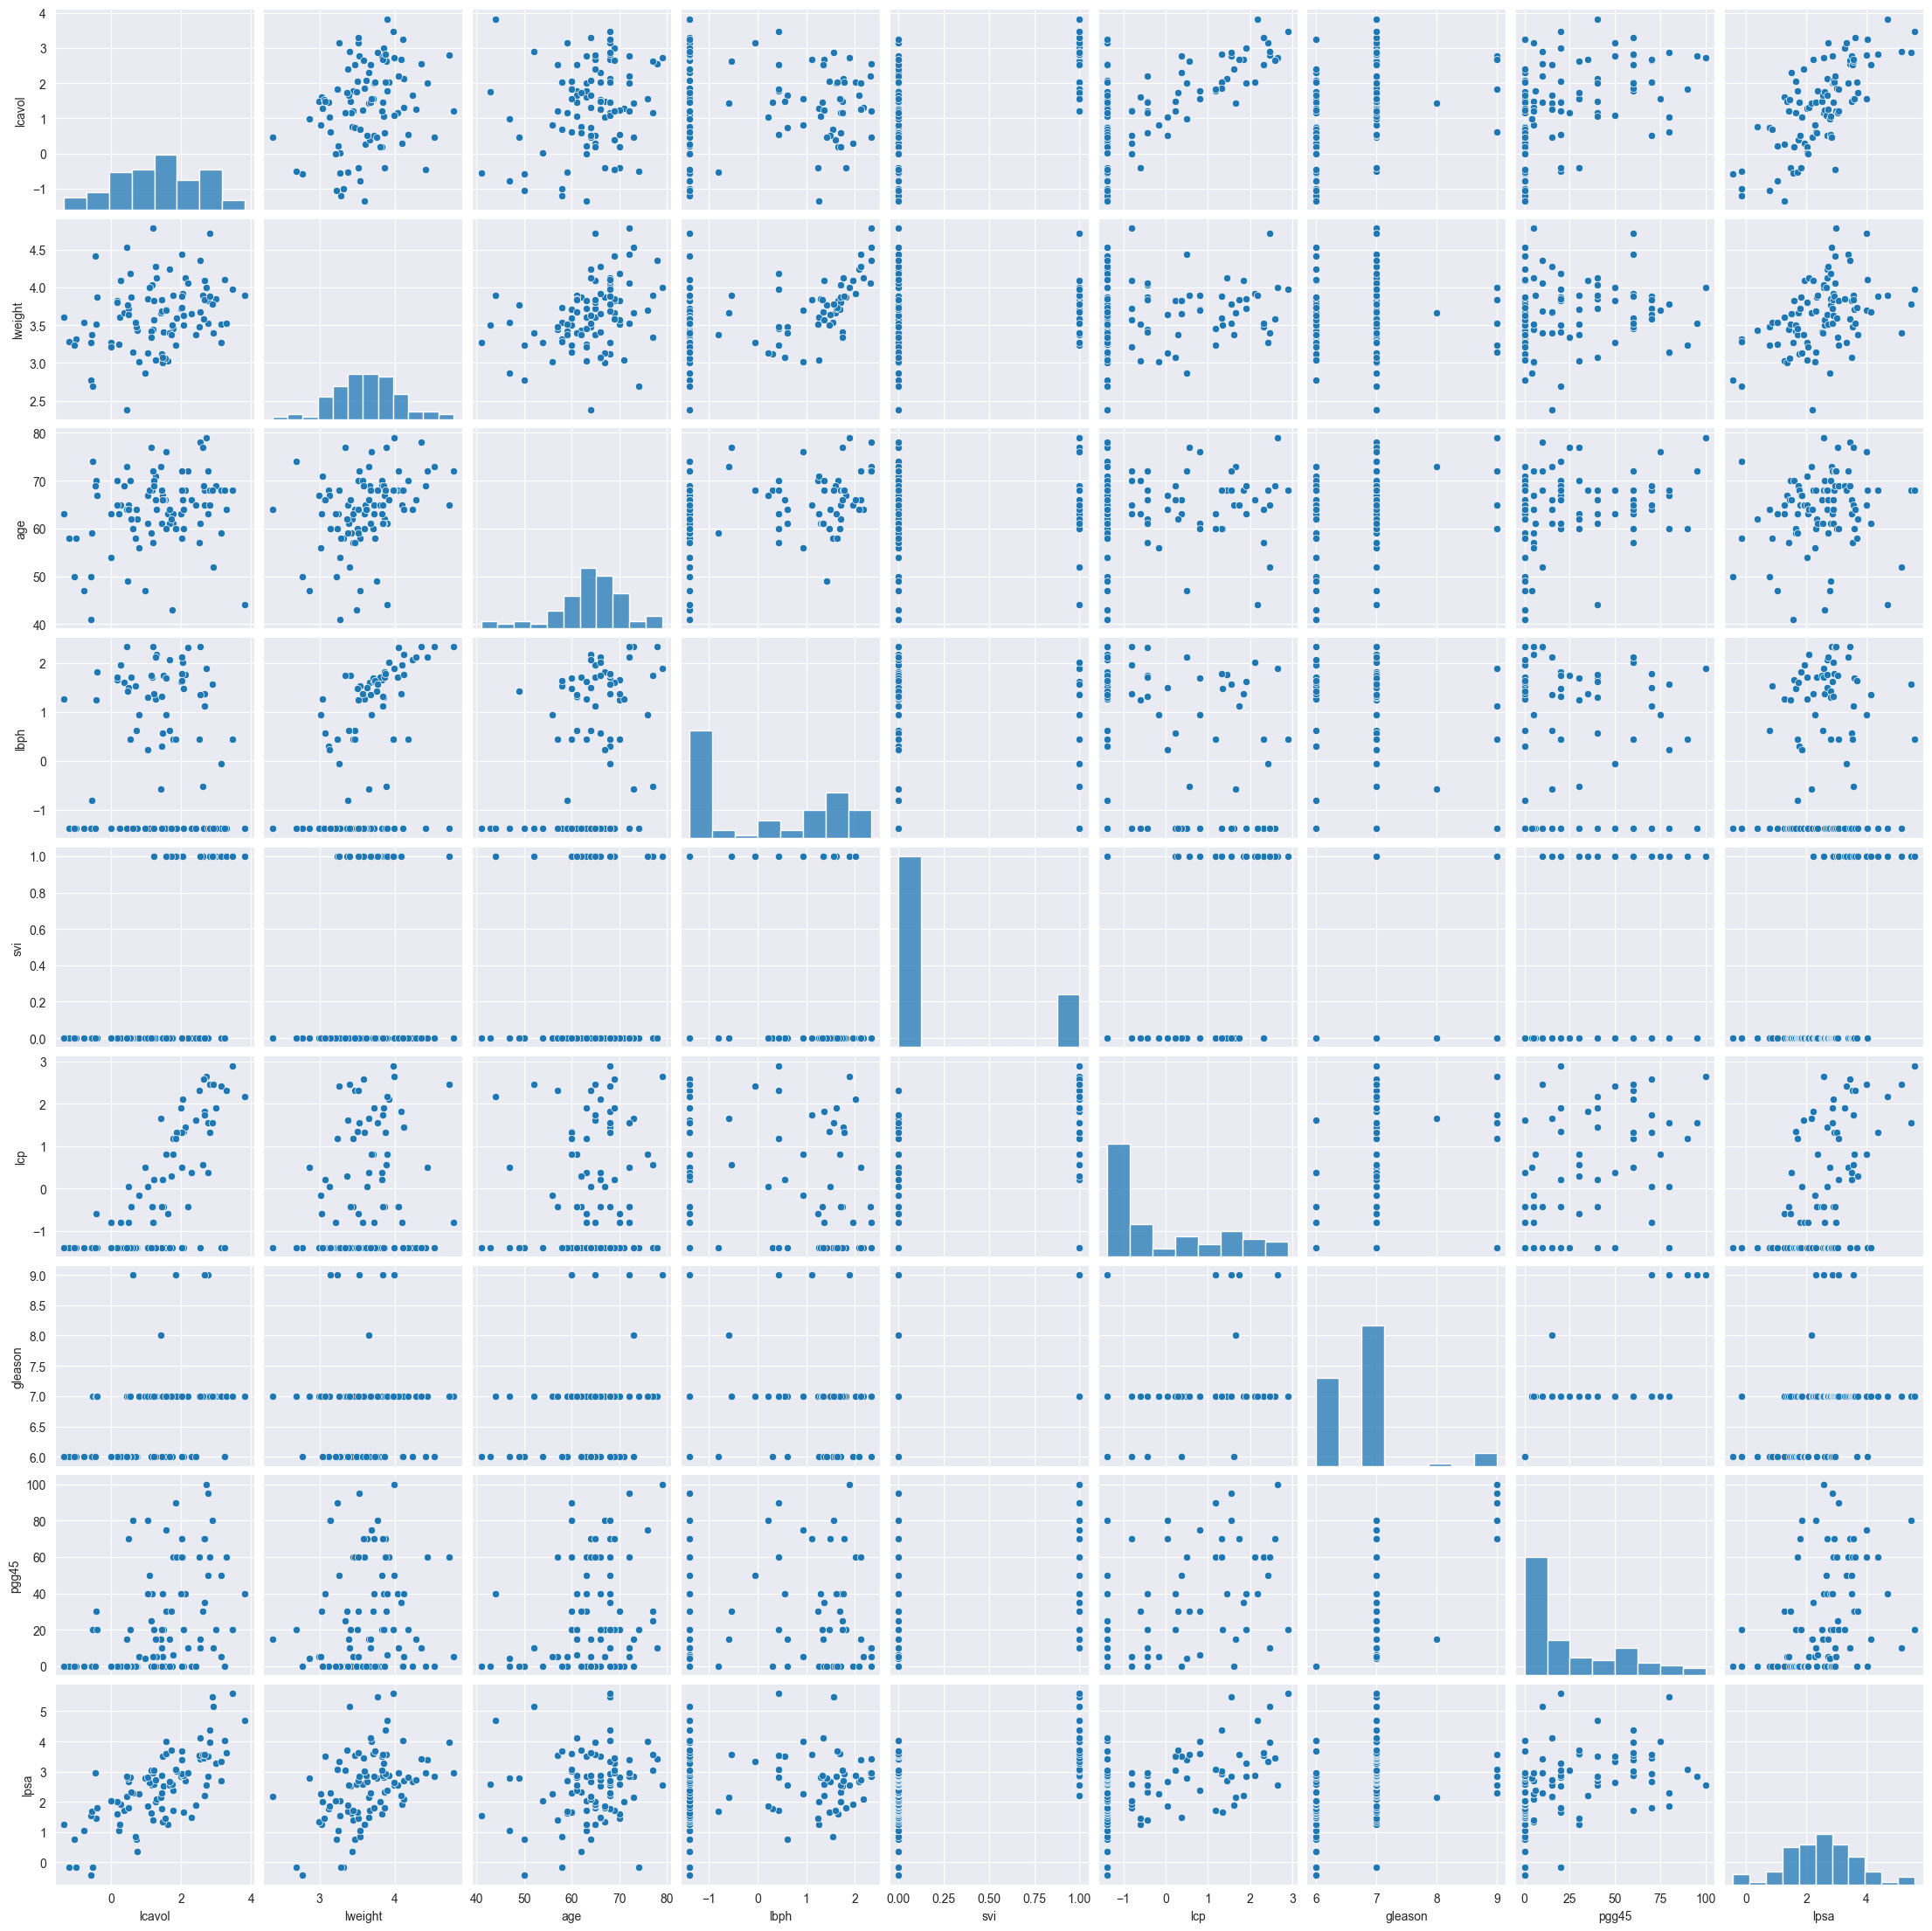

In [12]:
sns.pairplot(data=df.drop(columns="train"))

Which of the predictors on the plot are categorical?

In [13]:
# Check correlations
corr = (df
        .drop(columns="train")
        .corr()
        .round(2))

# Round the values for for your convenience
print(corr)

         lcavol  lweight   age  lbph   svi   lcp  gleason  pgg45  lpsa
lcavol     1.00     0.28  0.22  0.03  0.54  0.68     0.43   0.43  0.73
lweight    0.28     1.00  0.35  0.44  0.16  0.16     0.06   0.11  0.43
age        0.22     0.35  1.00  0.35  0.12  0.13     0.27   0.28  0.17
lbph       0.03     0.44  0.35  1.00 -0.09 -0.01     0.08   0.08  0.18
svi        0.54     0.16  0.12 -0.09  1.00  0.67     0.32   0.46  0.57
lcp        0.68     0.16  0.13 -0.01  0.67  1.00     0.51   0.63  0.55
gleason    0.43     0.06  0.27  0.08  0.32  0.51     1.00   0.75  0.37
pgg45      0.43     0.11  0.28  0.08  0.46  0.63     0.75   1.00  0.42
lpsa       0.73     0.43  0.17  0.18  0.57  0.55     0.37   0.42  1.00


In [14]:
# Partition the original data into training and testing datasets
train, test = df.loc[df.train=="T"].drop(columns="train"), df.loc[df.train=="F"].drop(columns="train")

In [15]:
train

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564
...,...,...,...,...,...,...,...,...,...
91,3.246491,4.101817,68,-1.386294,0,-1.386294,6,0,4.029806
92,2.532903,3.677566,61,1.348073,1,-1.386294,7,15,4.129551
93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147
94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443


In [16]:
# Scale to standardize mean and sd
trainst = (train.loc[:, :"pgg45"] -
           train.loc[:, :"pgg45"].mean()) / train.loc[:, :"pgg45"].std()

testst = (test.loc[:, :"pgg45"] -
           test.loc[:, :"pgg45"].mean()) / test.loc[:, :"pgg45"].std()

trainst["lpsa"] = train["lpsa"]
testst["lpsa"] = test["lpsa"]

In [17]:
# Fit linear model on training dataset using LS method
model = sm.OLS(endog=trainst["lpsa"], exog=sm.add_constant(trainst[["lcavol", "lweight", "age", "lbph",
                                                                    "svi", "lcp",
                                                                    "gleason", "pgg45"]]))

In [18]:
# Print the fit summary
fitls = model.fit()
print(fitls.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Fri, 16 May 2025   Prob (F-statistic):           2.04e-12
Time:                        11:01:04   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.0

To test the hypothesis that a particular coefficient $\beta_j = 0$, we form the standardized coefficient of Z-score (**t value** in the fit summary table)

$$z_j = \frac{\hat{\beta}_j}{\hat{\sigma}\sqrt{v_j}}$$

Where $v_j$ is the *j*th diagonal element of $(\boldsymbol{X}^T \boldsymbol{X})^{-1}$. Z-scores measure the effect of dropping that variable from the model.

In [19]:
# Drop the less significant predictors: age, lcp, gleason, pgg45 and repeat the fit
model = sm.OLS(endog=trainst["lpsa"], exog=sm.add_constant(trainst[["lcavol", "lweight", "lbph", "svi"]]))

In [20]:
# Summary for the reduced model
fitlsr = model.fit()
print(fitlsr.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     29.98
Date:                Fri, 16 May 2025   Prob (F-statistic):           6.91e-14
Time:                        11:01:10   Log-Likelihood:                -71.156
No. Observations:                  67   AIC:                             152.3
Df Residuals:                      62   BIC:                             163.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.089     27.592      0.0

Often we need to test for the significance of groups of coefficients simultaneously. The F-statistic can be solution:

$$F = \frac{(\mathrm{RSS}_0 - \mathrm{RSS}_1 )/(p_1 - p_0)}{\mathrm{RSS}_1 / (N - p_1 - 1)}$$

where RSS$_1$ is the residual sum-of-squares for the least squares fit of the bigger model with $p_1 + 1$ parameters, and RSS$_0$ the same for the nested small model with $p_0 + 1$ parameters, having $p_1 - p_0$ parameters constrained to be zero.

In [21]:
fitls

In [22]:
# sum of squares due to regression (SSR)

# RSS1 (for 'fitls')
RSS1 = fitls.ssr

# RSS0 (for 'fitlsr')
RSS0 = fitlsr.ssr

print("RSS0 =", RSS0)
print("RSS1 =", RSS1)

RSS0 = 32.81499474881555
RSS1 = 29.426384459908405


In [23]:
# F-statistic

# The model degree of freedom (.df_model)
# The residual degree of freedom (.df_resid)
F = ((RSS0 - RSS1) / (fitls.df_model - fitlsr.df_model)) / (RSS1 / fitls.df_resid)
print("F-statistic:", F)

F-statistic: 1.6697548846375179


In [24]:
# Call the cumulative distribution function (CDF) for F-statistic and calculate the p-value
p_val = 1 - f.cdf(F, fitls.df_model - fitlsr.df_model, fitls.df_resid)
print("p-value:", p_val)

p-value: 0.16933707265225284


Is the p-value significant or not?

# Subset Selection
In this method, for each integer ranging from 0 to $p$, we find the subset of predictors that gives the smallest RSS.

In [25]:
train_features = train.drop(columns="lpsa").columns.values
results_bss = pd.DataFrame(columns=np.append(train_features, ["model_size", "RSS"]))
input_combinations = [list(itertools.combinations(train_features, r=i)) for i in range(len(train_features) + 1)]

In [26]:
print("model_size", "cnt", "\n\t\t", *train_features, "  RSS")

for size in range(len(train.drop(columns="lpsa").columns) + 1):
  for cnt, predictors in enumerate(input_combinations[size]):
    results_bss.loc[-1, train_features] = "-"
    results_bss.loc[-1, list(predictors)] = "*"

    # fitting the OLS
    model = sm.OLS(endog=train["lpsa"], exog=sm.add_constant(train[list(predictors)]))
    RSS = model.fit().ssr

    results_bss.loc[-1, ["model_size", "RSS"]] = [size, RSS]

    print("{0:6d} {1:>7}) {2:>6} {3:>6} {4:>5} {5:>4} {6:>3} {7:>3} {8:>6} {9:>6} {10:>6.1f}".format(
        size, "(" + str(cnt+1), results_bss.loc[-1, "lcavol"],
        results_bss.loc[-1, "lweight"], results_bss.loc[-1, "age"],
        results_bss.loc[-1, "lbph"], results_bss.loc[-1, "svi"],
        results_bss.loc[-1, "lcp"], results_bss.loc[-1, "gleason"],
        results_bss.loc[-1, "pgg45"], results_bss.loc[-1, "RSS"]))
    results_bss = results_bss.reset_index(drop=True)

model_size cnt 
		 lcavol lweight age lbph svi lcp gleason pgg45   RSS
     0      (1)      -      -     -    -   -   -      -      -   96.3
     1      (1)      *      -     -    -   -   -      -      -   44.5
     1      (2)      -      *     -    -   -   -      -      -   73.6
     1      (3)      -      -     *    -   -   -      -      -   91.3
     1      (4)      -      -     -    *   -   -      -      -   89.6
     1      (5)      -      -     -    -   *   -      -      -   66.4
     1      (6)      -      -     -    -   -   *      -      -   73.2
     1      (7)      -      -     -    -   -   -      *      -   85.0
     1      (8)      -      -     -    -   -   -      -      *   77.0
     2      (1)      *      *     -    -   -   -      -      -   37.1
     2      (2)      *      -     *    -   -   -      -      -   44.5
     2      (3)      *      -     -    *   -   -      -      -   40.0
     2      (4)      *      -     -    -   *   -      -      -   42.3
     2      (5)    

     4     (40)      -      *     *    -   *   *      -      -   49.8
     4     (41)      -      *     *    -   *   -      *      -   48.0
     4     (42)      -      *     *    -   *   -      -      *   47.4
     4     (43)      -      *     *    -   -   *      *      -   54.5
     4     (44)      -      *     *    -   -   *      -      *   53.5
     4     (45)      -      *     *    -   -   -      *      *   56.9
     4     (46)      -      *     -    *   *   *      -      -   46.7
     4     (47)      -      *     -    *   *   -      *      -   45.7
     4     (48)      -      *     -    *   *   -      -      *   44.7
     4     (49)      -      *     -    *   -   *      *      -   53.4
     4     (50)      -      *     -    *   -   *      -      *   52.2
     4     (51)      -      *     -    *   -   -      *      *   56.4
     4     (52)      -      *     -    -   *   *      *      -   47.7
     4     (53)      -      *     -    -   *   *      -      *   47.3
     4     (54)     

In [27]:
num_best_subsets = 70
best_subsets = (results_bss
                .sort_values(by="RSS")
                .reset_index(drop=True)
                .loc[:num_best_subsets-1])

<Axes: xlabel='model_size', ylabel='Count'>

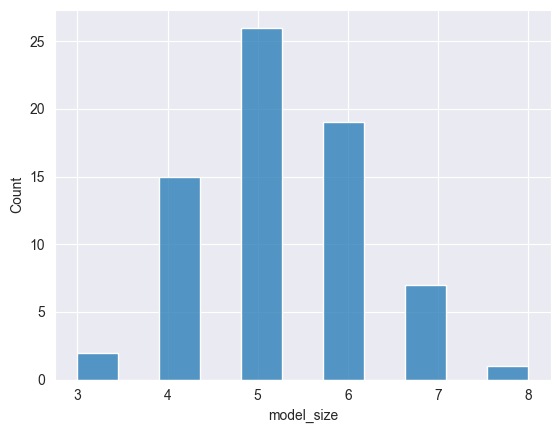

In [28]:
sns.histplot(data=best_subsets, x="model_size", stat="count")

In [29]:
best_subsets_min_RSS = results_bss[["model_size", "RSS"]].groupby(["model_size"], as_index=False).min()
best_subsets_min_RSS

,model_size,RSS
0,0,96.281445
1,1,44.528583
2,2,37.091846
3,3,34.907749
4,4,32.814995
5,5,32.069447
6,6,30.539778
7,7,29.4373
8,8,29.426384


Text(0, 0.5, 'Residual Sum-of-Squares')

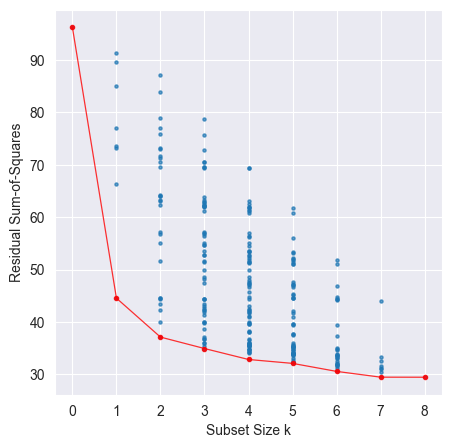

In [30]:
fig, ax = plt.subplots(figsize = (5,5))

ax.scatter(x=results_bss["model_size"], y=results_bss["RSS"], alpha=0.7, s=5)
ax.plot(best_subsets_min_RSS["model_size"], best_subsets_min_RSS["RSS"],
        color="red", alpha=0.8, linewidth=0.9, marker=".")
ax.set_xlabel("Subset Size k")
ax.set_ylabel("Residual Sum-of-Squares")

In [31]:
# check the best subset of size 5
results_bss.loc[results_bss.model_size == 5].sort_values(by="RSS").head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,model_size,RSS
175,*,*,-,*,*,-,-,*,5,32.069447
180,*,*,-,-,*,*,-,*,5,32.217533
163,*,*,*,*,*,-,-,-,5,32.284437
173,*,*,-,*,*,*,-,-,5,32.322837
174,*,*,-,*,*,-,*,-,5,32.636848


In [32]:
# The best subset of size 5 contains lcavol, lweight, lbph, svi & pgg45

In [33]:
# check the best subset of size 2
results_bss.loc[results_bss.model_size == 2].sort_values(by="RSS").head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,model_size,RSS
9,*,*,-,-,-,-,-,-,2,37.091846
11,*,-,-,*,-,-,-,-,2,39.992304
12,*,-,-,-,*,-,-,-,2,42.312584
15,*,-,-,-,-,-,-,*,2,43.423104
14,*,-,-,-,-,-,*,-,2,44.424078


In [34]:
# The best subset of size 2 contains lcavol & lweight

# Shrinkage Methods
Unlike the subset selection where variables are either retained or discarded (discrete process), shrinkage methods are more continuous. Consequently, they are able to reduce the prediction error of the model.

## Ridge Regression
Ridge regression shrinks the regression coefficients by imposing a penalty on their size.

$$\hat{\beta}^{ridge} = argmin_\beta \{\sum_{i=1}^N(y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2 + \alpha \sum_{j=1}^p \beta_j^2\}$$

Writing the criterion before in matrix form

$$\mathrm{RSS}(\alpha) = (\boldsymbol{y} - \boldsymbol{X}\beta)^T (\boldsymbol{y} - \boldsymbol{X}\beta) + \alpha\beta^T\beta = \mathrm{RSS}(\beta) + \alpha\beta^T\beta$$

The ridge regression solutions are

$$\hat{\beta}^{ridge} = (\boldsymbol{X}^T\boldsymbol{X} + \alpha\boldsymbol{I})^{-1}\boldsymbol{X}^T\boldsymbol{y}$$

In [35]:
# Ridge regression with built-in cross-validation (RidgeCV)

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE

In [36]:
model_ridge = Ridge(alpha=0.5)
model_ridge.fit(X=trainst.drop(columns="lpsa"), y=trainst["lpsa"])

Ridge(alpha=0.5)

In [37]:
print("(Intercept) {0:.3f}".format(model_ridge.intercept_))
for i, feature_name in enumerate(model_ridge.feature_names_in_):
    print("{0:<11} {1:.3f}".format(feature_name, model_ridge.coef_[i]))

(Intercept) 2.452
lcavol      0.703
lweight     0.292
age         -0.139
lbph        0.211
svi         0.307
lcp         -0.272
gleason     -0.016
pgg45       0.267


In [38]:
alphas_grid = [10**(i/10) for i in range(-20, 70)]
model_ridge_CV = RidgeCV(alphas=alphas_grid, cv=None, store_cv_values=True)
model_ridge_CV.fit(X=trainst.drop(columns="lpsa"), y=trainst["lpsa"])

/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


RidgeCV(alphas=[0.01, 0.012589254117941675, 0.015848931924611134,
                0.0199526231496888, 0.025118864315095794, 0.03162277660168379,
                0.039810717055349734, 0.05011872336272722, 0.06309573444801933,
                0.07943282347242814, 0.1, 0.12589254117941673,
                0.15848931924611134, 0.19952623149688797, 0.251188643150958,
                0.31622776601683794, 0.3981071705534972, 0.5011872336272722,
                0.6309573444801932, 0.7943282347242815, 1.0, 1.2589254117941673,
                1.5848931924611136, 1.9952623149688795, 2.51188643150958,
                3.1622776601683795, 3.9810717055349722, 5.011872336272722,
                6.309573444801933, 7.943282347242816, ...],
        store_cv_values=True)

/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/25/j6_kp1v55376c5ldy5f8ns1r0000gn/T/ipykernel_57529/1720792236.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


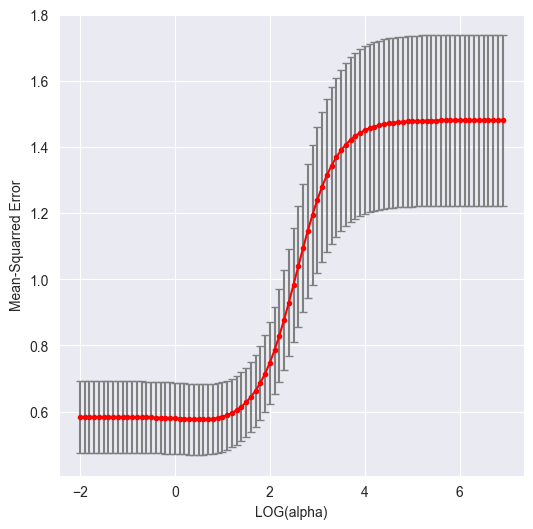

In [39]:
results_CV_mean = np.mean(model_ridge_CV.cv_values_, axis=0)
results_CV_std = np.std(model_ridge_CV.cv_values_, axis=0)
n = len(model_ridge_CV.cv_values_)


fig, ax = plt.subplots(figsize = (6,6))
ax.errorbar(x=np.log10(alphas_grid), y=results_CV_mean,
            yerr=results_CV_std/np.sqrt(n), ecolor="grey", capsize=3,
            color="red", marker='o', ms=3)

ax.set_xlabel("LOG(alpha)")
ax.set_ylabel("Mean-Squarred Error")
fig.show()

In [40]:
# The best alpha chosen by Leave-One-Out Cross-Validation.
model_ridge_CV.alpha_

3.9810717055349722

In [41]:
# Apply Ridge regression with chosen alpha
model_ridge = Ridge(alpha=model_ridge_CV.alpha_)
model_ridge.fit(X=trainst.drop(columns="lpsa"), y=trainst["lpsa"])

# Fitted coefficients
print("(Intercept) {0:.3f}".format(model_ridge.intercept_))
for i, feature_name in enumerate(model_ridge.feature_names_in_):
  print("{0:<11} {1:.3f}".format(feature_name, model_ridge.coef_[i]))

(Intercept) 2.452
lcavol      0.627
lweight     0.288
age         -0.116
lbph        0.204
svi         0.289
lcp         -0.180
gleason     0.008
pgg45       0.216


In [42]:
# Coefficients of an ordinary least squares
print(fitls.summary())

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Fri, 16 May 2025   Prob (F-statistic):           2.04e-12
Time:                        11:03:43   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.0

In [43]:
# Estimating mean prediction error
test_ridge = model_ridge.predict(testst.drop(columns="lpsa"))

# mean (absolute) prediction error
print("MAE:", MAE(y_true=testst["lpsa"], y_pred=test_ridge))

# mean (squared) prediction error
print("MSE:", MSE(y_true=testst["lpsa"], y_pred=test_ridge))

# standard error of mean (squared) prediction error
print("SE:", np.std((testst["lpsa"]-test_ridge)**2)/np.sqrt(30))

MAE: 0.5223433740475343
MSE: 0.5220292152879393
SE: 0.15985295748336303


## Lasso Regression
The Lasso is a shrinkage method like ridge. The main difference is that lasso penalty makes the solutions nonlinear in the $y_i$, and there is no closed form expression as in ridge regression.

$$\hat{\beta}^{lasso} = argmin_\beta \{\frac{1}{2}\sum_{i=1}^N(y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2 + \alpha \sum_{j=1}^p |\beta_j|)\}$$

In [44]:
from sklearn.linear_model import Lasso, LassoCV

In [45]:
alphas_grid = [10**(i/10) for i in range(-70, 1)]
model_lasso_CV = LassoCV(alphas=alphas_grid, cv=10, n_jobs=-1)
model_lasso_CV.fit(X=trainst.drop(columns="lpsa"), y=trainst["lpsa"])

LassoCV(alphas=[1e-07, 1.2589254117941662e-07, 1.584893192461114e-07,
                1.9952623149688787e-07, 2.5118864315095823e-07,
                3.162277660168379e-07, 3.981071705534969e-07,
                5.011872336272725e-07, 6.30957344480193e-07,
                7.943282347242822e-07, 1e-06, 1.2589254117941661e-06,
                1.584893192461114e-06, 1.9952623149688787e-06,
                2.5118864315095823e-06, 3.162277660168379e-06,
                3.981071705534969e-06, 5.011872336272725e-06,
                6.30957344480193e-06, 7.943282347242822e-06, 1e-05,
                1.2589254117941661e-05, 1.584893192461114e-05,
                1.9952623149688786e-05, 2.5118864315095822e-05,
                3.1622776601683795e-05, 3.9810717055349695e-05,
                5.011872336272725e-05, 6.309573444801929e-05,
                7.943282347242822e-05, ...],
        cv=10, n_jobs=-1)

/var/folders/25/j6_kp1v55376c5ldy5f8ns1r0000gn/T/ipykernel_57529/75852723.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


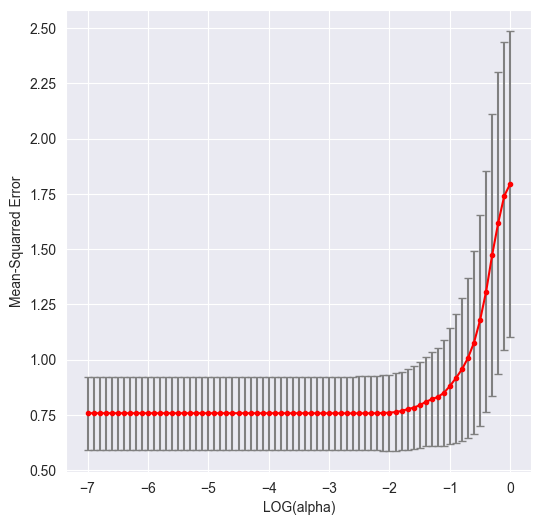

In [46]:
results_CV_mean = np.mean(model_lasso_CV.mse_path_, axis=1)
results_CV_std = np.std(model_lasso_CV.mse_path_, axis=1)

n = len(model_lasso_CV.mse_path_[0])

fig, ax = plt.subplots(figsize = (6,6))
ax.errorbar(x=np.log10(model_lasso_CV.alphas_), y=results_CV_mean,
            yerr=results_CV_std/np.sqrt(n), ecolor="grey", capsize=3,
            color="red", marker='o', ms=3)

ax.set_xlabel("LOG(alpha)")
ax.set_ylabel("Mean-Squarred Error")
fig.show()

In [47]:
# The best alpha chosen by 10-fold cross-validation
model_lasso_CV.alpha_

0.0031622776601683794

In [48]:
# Apply Lasso with chosen lambda
model_lasso = Lasso(alpha=model_lasso_CV.alpha_)
model_lasso.fit(X=trainst.drop(columns="lpsa"), y=trainst["lpsa"])


# Fitted coefficients
print("(Intercept) {0:.3f}".format(model_lasso.intercept_))
for i, feature_name in enumerate(model_lasso.feature_names_in_):
  print("{0:<11} {1:.3f}".format(feature_name, model_lasso.coef_[i]))

(Intercept) 2.452
lcavol      0.705
lweight     0.292
age         -0.137
lbph        0.208
svi         0.304
lcp         -0.268
gleason     -0.007
pgg45       0.257


In [49]:
# Estimating mean prediction error
test_lasso = model_lasso.predict(testst.drop(columns="lpsa"))

# mean (absolute) prediction error
print("MAE:", MAE(y_true=testst["lpsa"], y_pred=test_lasso))

# mean (squared) prediction error
print("MSE:", MSE(y_true=testst["lpsa"], y_pred=test_lasso))

# standard error of mean (squared) prediction error
print("SE:", np.std((testst["lpsa"]-test_lasso)**2)/np.sqrt(30))

MAE: 0.5294561497069384
MSE: 0.540455702985864
SE: 0.16641736540120008


## Elastic-net penalty
A compromise between ridge and lasso is called elastic-net. The method selects variables like the lasso, and shrinks together the coefficients of correlated predictors like ridge. The penalty for elastic-net is:

$$\alpha \sum_{j=1}^p (\lambda \beta_j^2 + (1 + \lambda)|\beta_j|)$$

In [50]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [51]:
# lambda stands for `l1_ratio`
alphas_grid = [10**(i/10) for i in range(-70, 1)]
model_elasticNet_CV = ElasticNetCV(l1_ratio=0.5, alphas=alphas_grid, cv=10)
model_elasticNet_CV.fit(X=trainst.drop(columns="lpsa"), y=trainst["lpsa"])

ElasticNetCV(alphas=[1e-07, 1.2589254117941662e-07, 1.584893192461114e-07,
                     1.9952623149688787e-07, 2.5118864315095823e-07,
                     3.162277660168379e-07, 3.981071705534969e-07,
                     5.011872336272725e-07, 6.30957344480193e-07,
                     7.943282347242822e-07, 1e-06, 1.2589254117941661e-06,
                     1.584893192461114e-06, 1.9952623149688787e-06,
                     2.5118864315095823e-06, 3.162277660168379e-06,
                     3.981071705534969e-06, 5.011872336272725e-06,
                     6.30957344480193e-06, 7.943282347242822e-06, 1e-05,
                     1.2589254117941661e-05, 1.584893192461114e-05,
                     1.9952623149688786e-05, 2.5118864315095822e-05,
                     3.1622776601683795e-05, 3.9810717055349695e-05,
                     5.011872336272725e-05, 6.309573444801929e-05,
                     7.943282347242822e-05, ...],
             cv=10)

/var/folders/25/j6_kp1v55376c5ldy5f8ns1r0000gn/T/ipykernel_57529/3601938851.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


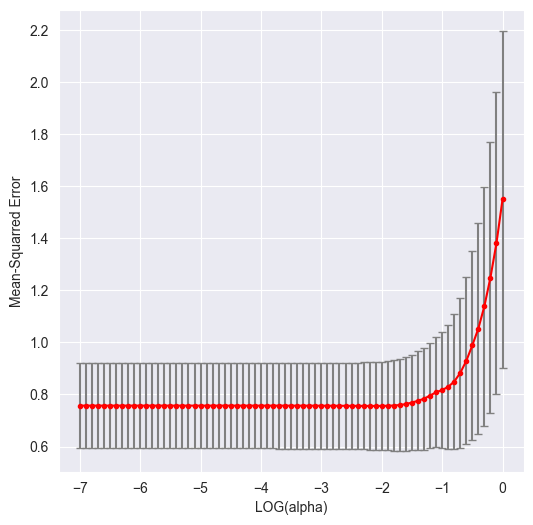

In [52]:
results_CV_mean = np.mean(model_elasticNet_CV.mse_path_, axis=1)
results_CV_std = np.std(model_elasticNet_CV.mse_path_, axis=1)

n = len(model_elasticNet_CV.mse_path_[0])

fig, ax = plt.subplots(figsize = (6,6))
ax.errorbar(x=np.log10(model_elasticNet_CV.alphas_), y=results_CV_mean,
            yerr=results_CV_std/np.sqrt(n), ecolor="grey", capsize=3,
            color="red", marker='o', ms=3)

ax.set_xlabel("LOG(alpha)")
ax.set_ylabel("Mean-Squarred Error")
fig.show()

In [53]:
# The best alpha chosen by 10-fold cross-validation
model_elasticNet_CV.alpha_

0.007943282347242814

In [54]:
# Apply Elastic net with chosen lambda
model_elasticNet = ElasticNet(alpha=model_elasticNet_CV.alpha_, l1_ratio=0.5)
model_elasticNet.fit(X=trainst.drop(columns="lpsa"), y=trainst["lpsa"])

# Fitted coefficients
print("(Intercept) {0:.3f}".format(model_elasticNet.intercept_))
for i, feature_name in enumerate(model_elasticNet.feature_names_in_):
  print("{0:<11} {1:.3f}".format(feature_name, model_elasticNet.coef_[i]))

(Intercept) 2.452
lcavol      0.696
lweight     0.291
age         -0.133
lbph        0.207
svi         0.301
lcp         -0.254
gleason     -0.002
pgg45       0.246


In [55]:
# Estimating mean prediction error
test_elasticNet = model_elasticNet.predict(testst.drop(columns="lpsa"))

# mean (absolute) prediction error
print("MAE:", MAE(y_true=testst["lpsa"], y_pred=test_elasticNet))

# mean (squared) prediction error
print("MSE:", MSE(y_true=testst["lpsa"], y_pred=test_elasticNet))

# standard error of mean (squared) prediction error
print("SE:", np.std((testst["lpsa"]-test_elasticNet)**2)/np.sqrt(30))

MAE: 0.5280537070089046
MSE: 0.5359428945383076
SE: 0.1645044797079284
